# Single Modal Distribution Lambda

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tfk.layers 
tfd = tfp.distributions
tfpl = tfp.layers

print("Tensorflow Version: %s" % tf.__version__)
print("Tensorflow Probability Version: %s" % tfp.__version__)

if tf.test.gpu_device_name() != '/device:GPU:0':
      print('GPU device not found. Using CPU')
else:
      print('Found GPU: {}'.format(tf.test.gpu_device_name()))

Tensorflow Version: 2.0.0-beta1
Tensorflow Probability Version: 0.8.0-dev20190619
Found GPU: /device:GPU:0


In [2]:
# commons package
import os
import sys
import importlib

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import commons as cm
importlib.reload(cm)

<module 'commons' from 'D:\\Tom\\Documents\\gitworkspace\\master\\ml-probability\\tfp_word_embeddings\\commons.py'>

# Configuration and Parameters

In [3]:
# GloVe Configuration

# Directory containing the GloVe files.
GLOVE_DIR = "D:/google drive/haw/master/mastertheisis/hauptprojekt"

# Embedding dimension
EMBEDDING_DIM = 50

In [4]:
imdb = cm.load_imdb()
(x_train, y_train), (x_test, y_test) = imdb

x_train, y_train, x_test, y_test = (x_train, y_train, x_test, y_test)

In [5]:
# Bayes by Backprop parameters

# model save file
model_save_file = "./models/distribution_lambda.h5"

# number of data points
N = x_train.shape[0]

# hidden layers where each element denotes the number of neurons
n_hidden = [64, 64, 32]

# batch size for training
batch_size = 128

# training epochs 
epochs = 30

# GloVe Word Embedding

In [6]:
# GLOVE Word Embedding
word_index = cm.WordIndex()
embedding_index = cm.load_glove_embedding(GLOVE_DIR, EMBEDDING_DIM)
(embedding_matrix, unknown_words) = word_index.match_glove(embedding_index=embedding_index, embedding_dim=EMBEDDING_DIM)
max_length = cm.get_max_length(x_train, x_test)

Found 400000 word vectors.
17361/88587 unknown words


In [7]:
# pad input vectors
x_train_padded = cm.pad_input(x_train, max_length)
x_test_padded = cm.pad_input(x_test, max_length)

# Model

In [8]:
# https://github.com/keras-team/keras/issues/5916

def negloglik(y, rv_y):
    return -rv_y.log_prob(y)

def create_model():
    model = tfk.Sequential()
    
    model.add(tfkl.Embedding(len(word_index.index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=max_length,
                                trainable=False))
    
    for i in range(len(n_hidden)):
        model.add(tfkl.Dense(n_hidden[i], activation="relu"))
        model.add(tfkl.Dropout(0.25))
    
    model.add(tfkl.Flatten())
    model.add(tfkl.Dense(1 + 1))
    model.add(tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(1e-2 * t[...,1:]))))
    
    model.compile(optimizer=tfk.optimizers.Adam(0.001), loss=negloglik, metrics=['acc'])

    return model

try:
    model = tfk.models.load_model(model_save_file, custom_objects={'negloglik': negloglik})
    print("using saved model")
except IOError:
    model = create_model()
    print("model has not been trained (IOError)")
model.summary()

using saved model
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 2697, 50)          4429400   
_________________________________________________________________
dense_28 (Dense)             (None, 2697, 64)          3264      
_________________________________________________________________
dropout_18 (Dropout)         (None, 2697, 64)          0         
_________________________________________________________________
dense_29 (Dense)             (None, 2697, 64)          4160      
_________________________________________________________________
dropout_19 (Dropout)         (None, 2697, 64)          0         
_________________________________________________________________
dense_30 (Dense)             (None, 2697, 32)          2080      
_________________________________________________________________
dropout_20 (Dropout)         (None, 

In [13]:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb
tb_callback = tfk.callbacks.TensorBoard(log_dir='logs') 
model_checkpoint_cb = tfk.callbacks.ModelCheckpoint(model_save_file, 
                                                      monitor='val_loss',
                                                      verbose=0, 
                                                      save_best_only=True, 
                                                      save_weights_only=False, 
                                                      mode='auto')

model.fit(x_train_padded, y_train, 
          validation_split=0.05, 
          epochs=epochs,
          batch_size=batch_size, 
          callbacks=[tb_callback, model_checkpoint_cb])

Train on 23750 samples, validate on 1250 samples
Epoch 1/30
23750/23750 [==============================] - 35s 1ms/sample - loss: 0.2739 - acc: 0.7658 - val_loss: 0.4089 - val_acc: 0.7024
Epoch 2/30
23750/23750 [==============================] - 34s 1ms/sample - loss: 0.2656 - acc: 0.7632 - val_loss: 0.4024 - val_acc: 0.7008
Epoch 3/30
23750/23750 [==============================] - 35s 1ms/sample - loss: 0.2649 - acc: 0.7750 - val_loss: 0.4136 - val_acc: 0.6848
Epoch 4/30
23750/23750 [==============================] - 34s 1ms/sample - loss: 0.2570 - acc: 0.7717 - val_loss: 0.4185 - val_acc: 0.7024
Epoch 5/30
23750/23750 [==============================] - 34s 1ms/sample - loss: 0.2608 - acc: 0.7705 - val_loss: 0.4128 - val_acc: 0.6816
Epoch 6/30
23750/23750 [==============================] - 34s 1ms/sample - loss: 0.2545 - acc: 0.7690 - val_loss: 0.4097 - val_acc: 0.7080
Epoch 7/30
23750/23750 [==============================] - 34s 1ms/sample - loss: 0.2558 - acc: 0.7698 - val_loss: 0.3

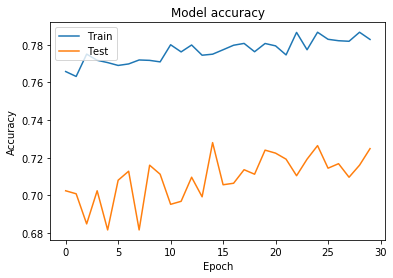

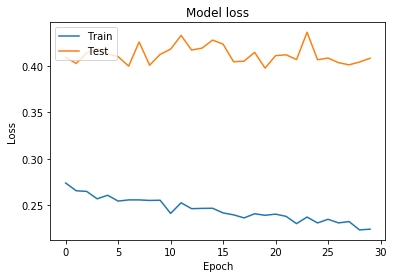

In [14]:
if hasattr(model, "history"):
    history = model.history

    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

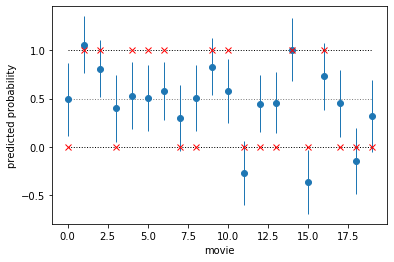

KL divergence: 3.65


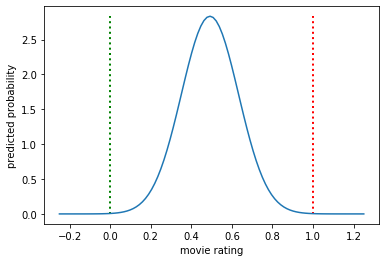

KL divergence: 0.24


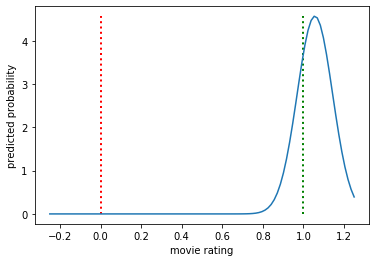

KL divergence: 0.65


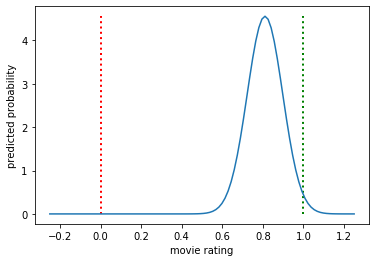

KL divergence: 2.43


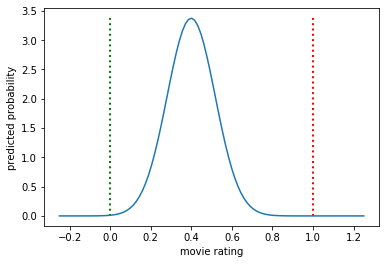

KL divergence: 3.23


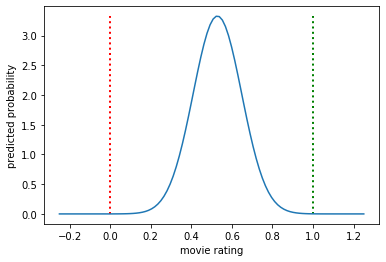

KL divergence: 3.48


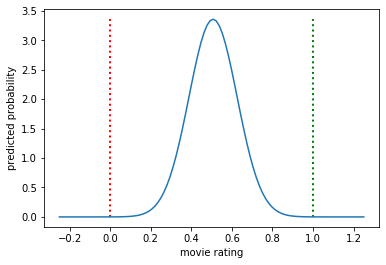

KL divergence: 2.44


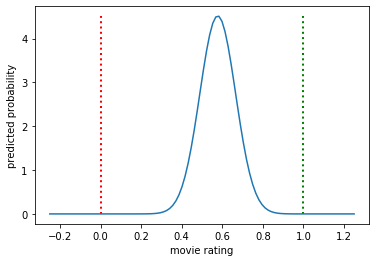

KL divergence: 1.56


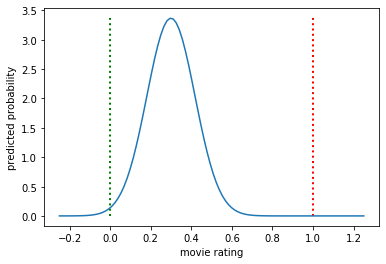

KL divergence: 3.65


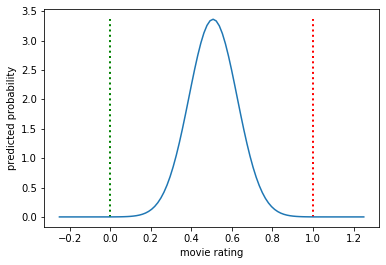

KL divergence: 0.56


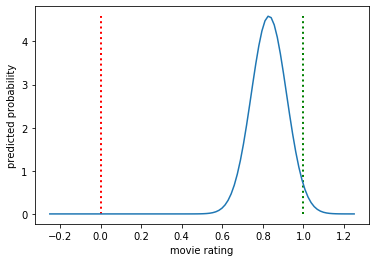

KL divergence: 2.56


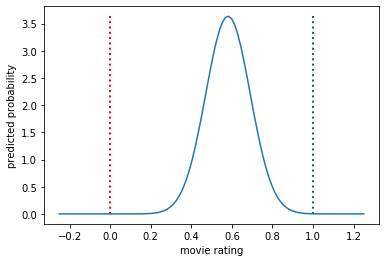

KL divergence: 1.29


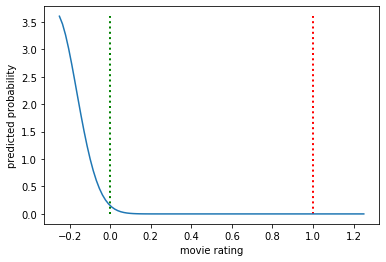

KL divergence: 2.69


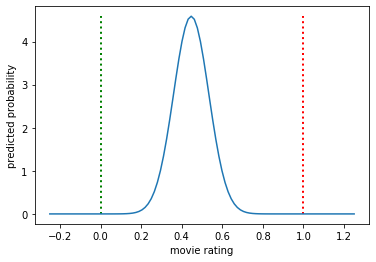

KL divergence: 2.93


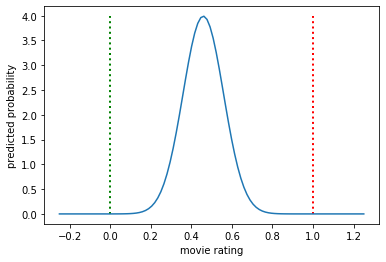

KL divergence: 0.33


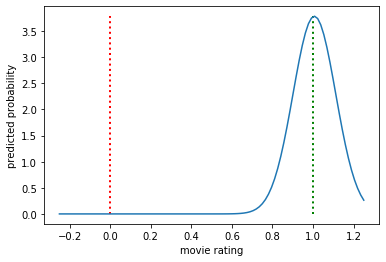

KL divergence: 2.02


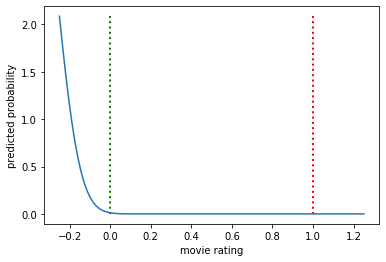

KL divergence: 1.35


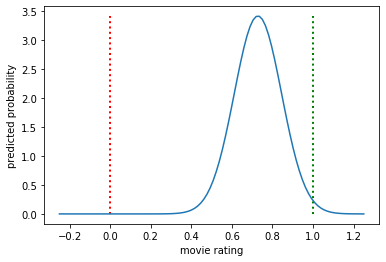

KL divergence: 3.01


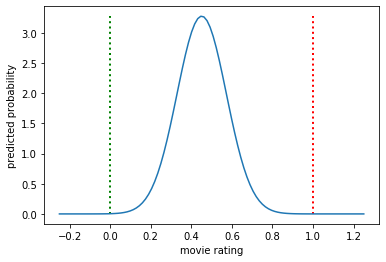

KL divergence: 0.69


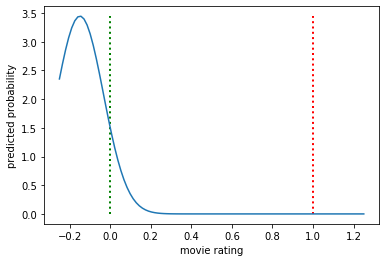

KL divergence: 1.87


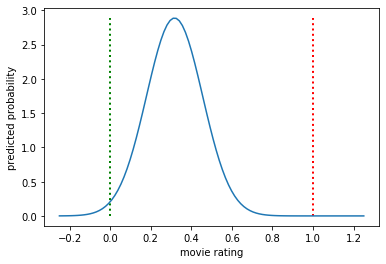

In [15]:
n_samples = 20
posterior = model(x_test_padded[:n_samples])
true_ys = y_test[:n_samples]

def create_pdf(mu, sigma):
    Z =  (2 * 3.1415 * sigma**2) ** 0.5
    return lambda x: tf.exp(-0.5 * (x - mu)**2 / sigma**2) / Z

def plot_independent(posterior, true_ys):
    for (mu, sigma, true_y) in zip(posterior.mean(), posterior.variance(), true_ys):
        dist = tfd.Normal(loc=mu, scale=tf.sqrt(sigma))
        pdf = create_pdf(mu, sigma)
        x = np.linspace(-0.25, 1.25, 100)
        y = np.array([pdf(x1) for x1 in x])
        y_max = np.max(y)

        true_dist = tfd.Normal(loc=float(true_y), scale=0.2)
        print("KL divergence: %.2f" % dist.kl_divergence(true_dist).numpy()[0])

        fig, ax = plt.subplots()
        ax.plot(x, y)
        color0 = ['g', 'r'][true_y]
        color1 = ['g', 'r'][1 - true_y]
        ax.vlines(x=[0, 1], ymin=0, ymax=y_max, linewidth=2, color=[color0, color1], linestyle=":")
        plt.xlabel("movie rating")
        plt.ylabel("predicted probability")

        plt.show()
        
def plot_confidence(posterior, true_ys):
    x = np.arange(0, posterior.shape[0], 1)
    y = np.squeeze(posterior.mean())
    yerr = np.squeeze(posterior.stddev())

    fig, ax = plt.subplots()
    plt.xlabel("movie")
    plt.ylabel("predicted probability")
    
    ax.hlines(y=[0, 0.5, 1], xmin=0, xmax=len(x) - 1, linewidth=1, linestyle=":", color=["black", "gray", "black"])
    ax.errorbar(x, y, yerr=yerr, fmt="o", elinewidth=1)
    ax.errorbar(x, true_ys, fmt="x", color="r")
    plt.show()

    
good_ratings = np.extract(true_ys == 1, posterior.mean().numpy()) 
bad_ratings = np.extract(true_ys == 1, posterior.mean().numpy()) 
plot_confidence(posterior, true_ys)
plot_independent(posterior, true_ys)